In [2]:
import os
import json
import h5py
import pickle
import numpy as np
import math
import tensorflow as tft
from tqdm import tqdm
from pathlib import PurePosixPath
import cv2
import os
from datetime import datetime
import matplotlib.gridspec as gridspec

from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ELU
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras import backend as K


Using TensorFlow backend.


# Steering Data Exploration 

In [3]:
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
from scipy.stats import norm
%matplotlib inline

In [4]:
log_path = './data'
column_names = ['center', 'left', 'right',
                'steering', 'throttle', 'brake', 'speed']
data_df = pd.read_csv(log_path+'/driving_log.csv')

In [5]:
data_df.iloc[:5]

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


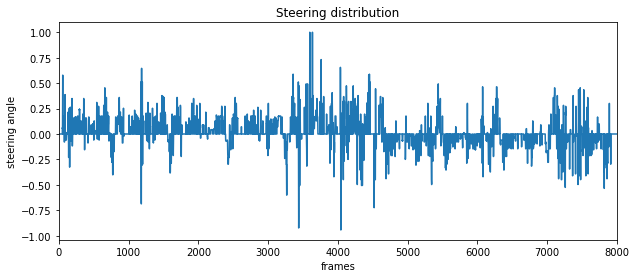

In [6]:
plt.figure(figsize=(10,4))
x = [range(len(data_df['steering']))]
x = np.squeeze(np.asarray(x))
y = np.asarray(data_df['steering'])
plt.xlim(0,8000)
plt.title('Steering distribution')
plt.xlabel('frames')
plt.ylabel('steering angle')
plt.plot(x,y)
plt.show()

In [7]:
# From steering distribution, we find that data is not heavily skewed by x-axis (evenly distributed)

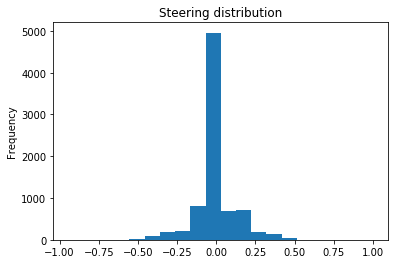

In [8]:
plt.title('Steering distribution')
data_df['steering'].plot.hist(bins=20)

In [9]:
data_df['steering'].describe()

count    8036.000000
mean        0.004070
std         0.128840
min        -0.942695
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64

In [73]:
data_df.query('steering == 0')['steering'].count()

4361

In [78]:
#It seems like steering for a majority portion of data is set at 0 (over 50% of data). 
#It may get to be difficult in training, as it is be more trained toward going straight.
#data is not well represented in the sense that we are interested in training for a track with curvatures.

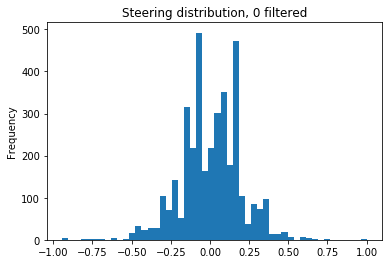

In [79]:
plt.title('Steering distribution, 0 filtered')
data_df.query('steering != 0')['steering'].plot.hist(bins=50)

In [70]:
data_df.query('steering != 0')['steering'].describe()

count    3675.000000
mean        0.008899
std         0.190422
min        -0.942695
25%        -0.107229
50%         0.013917
75%         0.147877
max         1.000000
Name: steering, dtype: float64

In [ ]:
#After removing all 0, its histogram seem to be well balanced. 

# Image Exploration

In [ ]:
num=300
offset=.25

In [32]:
def image_files(path,camera='center'):
    return[path+f for f in os.listdir(path) if camera in str(f)]

In [36]:
center_camera_files=image_files(log_path+'/IMG/')
left_camera_files=image_files(log_path+'/IMG/',camera='left')
right_camera_files=image_files(log_path+'/IMG/',camera='right')
print(len(left_camera_files),len(center_camera_files),len(right_camera_files))

8036 8036 8036


In [243]:
center_list= data_df['center']
left_list= data_df['left']
right_list= data_df['right']
steer_list = data_df['steering']

In [99]:
def load_image(log_path, filename):
    filename = filename.strip()
    if filename.startswith('IMG'):
        filename = log_path+'/'+filename
    else:
        # load it relative to where log file is now, not whats in it
        filename = log_path+'/IMG/'+PurePosixPath(filename).name

    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [244]:
center_img, center_steering = load_image(log_path,center_list[num]), steer_list[num]
left_img, left_steering = load_image(log_path,left_list[num]), steer_list[num] + offset
right_img, right_steering = load_image(log_path,right_list[num]), steer_list[num] - offset

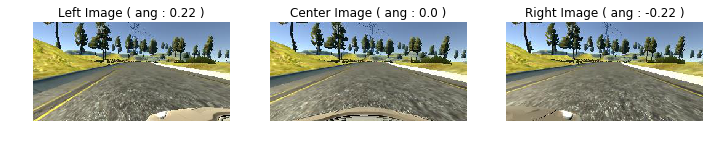

In [245]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(left_img)
plt.title('Left Image ( ang : ' + str(np.round(left_steering,3)) + ' )')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(center_img)
plt.title('Center Image ( ang : ' + str(np.round(center_steering,3)) + ' )')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(right_img)
plt.title('Right Image ( ang : ' + str(np.round(right_steering,3)) + ' )')
plt.axis('off')
plt.show()

In [113]:
# I would like to use left and right images for training as well as center ones, 
#adding offsets has been recommended in multiple forum threads to take into account of angle.

## Augment image data 

In [ ]:
# Referred https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.v76laaz7d

In [299]:
def random_brightness(image):
    """
    randomly change brightness by converting Y value
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # brightness
    bv = .3 + np.random.random()
    hsv[::2] = hsv[::2]*bv
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def random_shift(image, steer):
    """
    randomly shift image horizontally &
    add proper steering angle to each image
    """
    max_shift = 50
    max_ang = 0.2  # ang_per_pixel = 0.004

    rows, cols, _ = image.shape

    random_x = np.random.randint(-max_shift, max_shift + 1)
    dst_steer = steer + (random_x / max_shift) * max_ang
    if abs(dst_steer) > 1:
        dst_steer = -1 if (dst_steer < 0) else 1

    mat = np.float32([[1, 0, random_x], [0, 1, 0]])
    dst_img = cv2.warpAffine(image, mat, (cols, rows))
    return dst_img, dst_steer

def random_shadow(image):
    """generate random shadow in random region"""
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image


def random_flip(image, steering):
    """ randomly flip image"""
    flip_image, flip_steering = cv2.flip(image, 1), -steering
    return flip_image, flip_steering

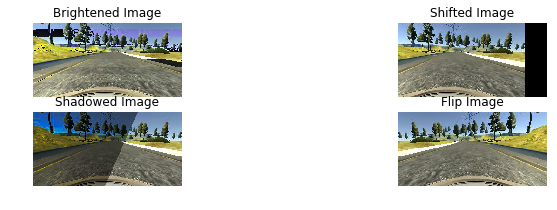

In [300]:
bright_image = random_brightness(center_img)
shift_image, shift_steer = random_shift(center_img, center_steering)
shadow_image = random_shadow(center_img)
flip_image, flip_steer = random_flip(center_img, center_steering)

plt.figure(figsize=(12,3))
plt.subplot(2,2,1)
plt.imshow(bright_image)
plt.title('Brightened Image')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(shift_image)
plt.title('Shifted Image')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(shadow_image)
plt.title('Shadowed Image')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(flip_image)
plt.title('Flip Image')
plt.axis('off')
plt.show()

## Preprocess

In [297]:
log_path = './data'

In [ ]:
def load_image(log_path, filename):
    filename = filename.strip()
    if filename.startswith('IMG'):
        filename = log_path+'/'+filename
    else:
        # load it relative to where log file is now, not whats in it
        filename = log_path+'/IMG/'+PurePosixPath(filename).name
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [295]:
new_size_col,new_size_row = 64, 64

def select_img(center_list, left_list, right_list, steer_list, num, offsets=0.25):
    """
    randomly select among center, left, right images
    """
    rand = np.random.randint(3)
    log_path = './data'
    if rand == 0:
        image, steer = load_image(log_path, center_list[num]), steer_list[num]
    elif rand == 1:
        image, steer = load_image(log_path, center_list[num]), steer_list[num] + offsets
    elif rand == 2:
        image, steer = load_image(log_path, center_list[num]), steer_list[num] - offsets
    
    
    if abs(steer) > 1:
        steer = -1 if (steer < 0) else 1
    return image, steer


def crop_resize(image):
    """
    Crop out top 1/5 of image and resize to 64x64
    """
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image,(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)  
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = image/255.-.5
    return image

def generate_train(center_list, left_list, right_list, steer_list):
    num = np.random.randint(0, len(steer_list))
    image, steer = select_img(center_list, left_list, right_list, steer_list, num)
     
    image,steer = random_shift(image, steer)
    image = random_brightness(image)
    image = random_shadow(image)
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image,steer = random_flip(image, steer)
    
    image = crop_resize(image)
    #image = np.array(image)
    return image, steer

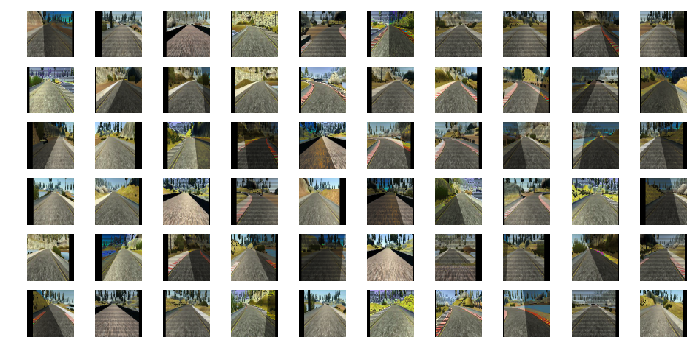

In [296]:
plt.figure(figsize=(12,6))
for i in range(60):
    image,steer = generate_train(center_list, left_list, right_list, steer_list)
    
    plt.subplot(6,10,i+1)
    plt.imshow(image);
    plt.axis('off')
plt.show()

# Movie

In [301]:
from moviepy.editor import *
from IPython.display import HTML

In [ ]:
# # if driving in a straight line remove extra rows
# def filter_driving_straight(data_df, hist_items=5):
#     print('filtering straight line driving with %d frames consective' %
#           hist_items)
#     steering_history = deque([])
#     drop_rows = []

#     for idx, row in data_df.iterrows():
#         # controls = [getattr(row, control) for control in vehicle_controls]
#         steering = getattr(row, 'steering')

#         # record the recent steering history
#         steering_history.append(steering)
#         if len(steering_history) > hist_items:
#             steering_history.popleft()

#         # if just driving in a straight
#         if steering_history.count(0.0) == hist_items:
#             drop_rows.append(idx)

#     # return the dataframe minus straight lines that met criteria
#     return data_df.drop(data_df.index[drop_rows])

